In [2]:
#!/usr/bin/env python 
# coding:utf-8

import time, argparse, gc, os
import sys
sys.path.append('/scratch-shared/akshai/workdir/smiles_vgg/supp_codes')
import tqdm

import numpy as np
import pandas as pd

from rdkit import Chem

from feature import *
import SCFPfunctions as Mf
import gc

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler

import sklearn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()
gc.collect()
torch.cuda.empty_cache()

In [4]:
# To remove rdkit warning

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [5]:
def remove_duplicates(filename):
    clean_file = filename[:-4] + "_out.txt"
    open_file = open(filename,"r").readlines()
    output = open(clean_file,"w")
    finished_list = []
    for entry in open_file:
        if entry.split()[0] not in finished_list:
            finished_list.append(entry.split()[0])
            output.write(entry.split()[0] + " " + entry.split()[1] + "\n")
    output.close()
    return clean_file
    
training_file=remove_duplicates("ML_input_5338.txt")

In [6]:
# Removing data with lower distribution
lower_label_count_cutoff = 10
upper_label_count_cutoff = 500
enable_label_cutoff = True
multi_files = False

if not multi_files and enable_label_cutoff:
    open_file = open(training_file,"r").readlines()
    
    # Find the  number of labels (count of each label)
    label_count_init = {}
    for entry in open_file:
        label = int(entry.split()[1])
        if label in label_count_init:
            label_count_init[label] += 1
        else:
            label_count_init[label] = 1
    
    # Select the label above the cutoff  (count of each label above cutoff)
    label_count = {}
    for entry in label_count_init:
        if label_count_init[entry] > lower_label_count_cutoff and label_count_init[entry] < upper_label_count_cutoff:
            label_count[entry] = label_count_init[entry]
    
    # Select only the smiles with labels above the cutoff
    smiles_label = {}
    allocated_label = []
    allowed_labels = sorted(label_count.keys())
    for entry in open_file:
        smiles = entry.split()[0]
        label = int(entry.split()[1])
        if label in allowed_labels:
            if label not in allocated_label:
                allocated_label.append(label)
            smiles_label[smiles] = allocated_label.index(label)
            

In [7]:
#ata_to_use = []
balanced_dat_out = open("balanced_dat.txt","w")
for entry in smiles_label:
    #data_to_use.append( str(entry) + " " + str(smiles_label[entry]) + "\n")
    balanced_dat_out.write( str(entry) + " " + str(smiles_label[entry]) + "\n")

balanced_dat_out.close()
training_file = "balanced_dat.txt"

In [8]:
allocated_label,label_count

([4, 3], {4: 228, 3: 259})

In [9]:
lensize = 42 # feature vector size
atomsize = 400 # max length of molecule

def make_grid(file):
    xp=np
    print('Loading smiles: ', file)
    smi = Chem.SmilesMolSupplier(file,delimiter=' ',titleLine=False)
    mols = [mol for mol in smi if mol is not None]
    
    F_list, T_list = [],[]
    for mol in mols:
        if len(Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)) > atomsize: print("too long mol was ignored")
        else:
            F_list.append(mol_to_feature(mol,-1,atomsize))
            T_list.append(mol.GetProp('_Name'))
    Mf.random_list(F_list)
    Mf.random_list(T_list)

    data_t = xp.asarray(T_list, dtype=xp.int32).reshape(-1,1)
    data_f = xp.asarray(F_list, dtype=xp.float32).reshape(-1,1,atomsize,lensize)

    dataset = (data_f,data_t)
    #train_dataset = datasets.TupleDataset(data_f, data_t) 
    print(data_t.shape, data_f.shape)
    
    return (data_f,data_t)
    
print('Making Training  Dataset...')
x, y = make_grid(training_file)

Making Training  Dataset...
Loading smiles:  balanced_dat.txt
(487, 1) (487, 1, 400, 42)


In [10]:
train_percentage = 0.7

valid_test_percentage = (1 - train_percentage)/2

data_to_use = x
# Ratios
train_ratio = int (len(data_to_use) * train_percentage)
valid_ratio = train_ratio + int(len(data_to_use)*valid_test_percentage)
test_ratio = valid_ratio + int(len(data_to_use)*valid_test_percentage)

In [11]:
# Make index to split into train and val set
np.random.seed(1)
def make_index(len_data,train_ratio,valid_ratio,test_ratio):
    
    index = np.random.permutation(len_data)
    
    # Train index and val index
    return (index[:train_ratio],index[train_ratio:valid_ratio],index[valid_ratio:test_ratio])

train_index ,valid_index,test_index = make_index(len(data_to_use),train_ratio,valid_ratio,test_ratio)

In [12]:
def get_data_with_index(x,y,index):
    out_x = []
    out_y = []
    for entry in index:
        out_x.append(x[entry])
        out_y.append(y[entry])
    
    return (np.array(out_x),np.array(out_y).squeeze())
        

train_x,train_y = get_data_with_index(x,y,train_index)
valid_x,valid_y = get_data_with_index(x,y,valid_index)
test_x,test_y = get_data_with_index(x,y,test_index)

In [13]:
def find_data_distribution(y):
    
    distribution_dict = {}
    for yone in y:
        #print (yone[0])
        yone = yone
        if yone in distribution_dict:
            distribution_dict[yone] += 1
        else:
            distribution_dict[yone] = 1
            
    total = len(y)
    higher_class = max(distribution_dict.values())

    random_prob = float(higher_class/total)
    print ("Random prediction %" + str(random_prob))
    print ("Class distribution count" + str(distribution_dict))
    
    
find_data_distribution(train_y)
find_data_distribution(valid_y)
find_data_distribution(test_y)

Random prediction %0.5323529411764706
Class distribution count{1: 181, 0: 159}
Random prediction %0.6164383561643836
Class distribution count{1: 45, 0: 28}
Random prediction %0.547945205479452
Class distribution count{1: 33, 0: 40}


In [14]:
train_xt = torch.from_numpy(train_x)
train_yt = torch.from_numpy(train_y)

valid_xt = torch.from_numpy(valid_x)
valid_yt = torch.from_numpy(valid_y)

test_xt = torch.from_numpy(test_x)
test_yt = torch.from_numpy(test_y)

In [54]:
train_dataset = torch.utils.data.TensorDataset(train_xt, train_yt)
valid_dataset = torch.utils.data.TensorDataset(valid_xt, valid_yt)
test_dataset = torch.utils.data.TensorDataset(test_xt, test_yt)


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

val_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

In [55]:
class_count_list = sorted(list(set(entry for entry in train_y)))
print (class_count_list)
for entry in train_y:
    class_count_list[entry] += 1
print (class_count_list)

[0, 1]
[159, 182]


In [56]:
class_count_list = np.array(class_count_list)
class_weight = np.min(class_count_list)/class_count_list
class_weight = torch.FloatTensor(class_weight).cuda()

#if not trial:
#    log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
class_weight

tensor([1.0000, 0.8736], device='cuda:0')

In [57]:
lensize = 42 # feature vector size
atomsize = 400 # max length of molecule
batchsize = 32
epochs = 20
atomsize = 400
protein = "SR-p53" # Protein subset (prefix of the files)
boost = -1 # Dont know this parameter yet

# k = window size
# s = strides
# f = number of filters

# first convolution
k1 = 11
s1 = 1
f1 = 128

# max pooling 1 
k2 = 5
s2 = 1

# second convolution
k3 = 11
s3 = 1
f3 = 64

# max pooling 2
k4 = 5
s4 = 1

# number of hidden layers
n_hid = 96
n_out = 2

optimizer='adam'

In [58]:
class Net(nn.Module):
    def __init__(self, atomsize, lensize, k1, s1, f1, k2, s2, k3, 
                 s3, f3, k4, s4, n_hid, n_out):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, f1, (k1,lensize),padding=(k1//2,0),stride=(s1,s1))
        self.bn1 = nn.BatchNorm2d(f1)
        self.leakyr = nn.LeakyReLU()
        self.pool1 = nn.AvgPool2d((k2,1),stride=(s2,s2),padding=(k2//2,0))
        self.conv2 = nn.Conv2d(f1,f3,(k3,1),stride=(s3,s3),padding=(k3//2,0))
        self.bn2 = nn.BatchNorm2d(f3)
        self.pool2 = nn.AvgPool2d((k4,1),stride=(s4,s4),padding=(k4//2,0))
        self.maxpool = nn.MaxPool2d(kernel_size=2),
        self.fc1 = nn.Linear(64, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn3 = nn.BatchNorm1d(n_hid)
        
        self.dropout = nn.Dropout(p=0.2)
        '''self.atomsize, self.lensize, self.n_out = atomsize, lensize, n_out
        self.k1, self.s1, self.f1, self.k2, self.s2, self.k3, self.s3, self.f3, self.k4, self.s4 = k1, s1, f1, k2, s2, k3, s3, f3, k4, s4
        self.l1 = (self.atomsize+(self.k1//2*2)-self.k1)//self.s1+1
        self.l2 = (self.l1+(self.k2//2*2)-self.k2)//self.s2+1
        self.l3 = (self.l2+(self.k3//2*2)-self.k3)//self.s3+1
        self.l4 = (self.l3+(self.k4//2*2)-self.k4)//self.s4+1'''
        
        
    def forward(self, x):
        x = self.pool1(self.leakyr(self.bn1(self.conv1(x))))
        x = self.pool2(self.leakyr(self.bn2(self.conv2(x))))
        #print (x.size(),x.size()[2:])
        x = F.max_pool2d(x,kernel_size=x.size()[2:])
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.dropout(self.leakyr(x))
        x = self.fc2(x)
        return x

n_out = len(class_weight)
model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weight)
#criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (conv1): Conv2d(1, 128, kernel_size=(11, 42), stride=(1, 1), padding=(5, 0))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyr): LeakyReLU(negative_slope=0.01)
  (pool1): AvgPool2d(kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  (conv2): Conv2d(128, 64, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=2, bias=True)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [59]:
gc.collect()

def get_accuracy(yhat,y):
    softmax = torch.exp(yhat.float())
    prob = list(softmax.cpu().detach().numpy())
    predictions = (np.argmax(prob, axis=1))
    return accuracy_score(y, predictions)

def validate(val_dl):
    model.eval()
    total_loss = []
    accuracy_list = []
    
    for i, (xval,yval) in enumerate(val_dl):
        xval = xval.to(device)
        yvalc = yval.to(device)
        
        output_val = model(xval.float())
        
        accuracy = get_accuracy(output_val,yval)
        
        accuracy_list.append(accuracy)
        
        loss_val = criterion(output_val, yvalc.long())
        
        total_loss.append(loss_val.item())
        
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)))

def train(train_dl,epoch=0):
    model.train()
    total_loss = []
    accuracy_list = []
    loop = tqdm.tqdm(enumerate(train_dl),total=len(train_dl),leave=False)
    for i, (xb,yb) in loop:
        
        xb = xb.to(device)
        ybc = yb.to(device)
        
        optimizer.zero_grad()
        
        output_train = model(xb.float())
        
        loss_train = criterion(output_train, ybc.long())
        
        accuracy = get_accuracy(output_train,yb)
        accuracy_list.append(accuracy)
        
        loss_train.backward()
        optimizer.step()
        
        total_loss.append(loss_train.item())
        
        #if i % 1000 == 0:
        #    print ("Batch " + str(i) + " train loss = " + str(sum(total_loss)/(i+1)) )
            
        gc.collect()
        loop.set_description("EPOCH " + str(epoch+1) + "/" + str(epochs)) # +  " BATCH = " + str(i) + "/" +  str(len(train_dl)) )
        loop.set_postfix(loss = loss_train.item(), acc=accuracy)
    
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)))



In [60]:
train_loss_list = []
train_accu_list = []

val_loss_list = []
val_accu_list = []

In [61]:
epochs = 500

for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_loader,epoch)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(val_loader)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)

    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)
        

EPOCH 2/500:  20%|██        | 1/5 [00:00<00:00,  8.90it/s, acc=0.766, loss=0.542]

Epoch : 1 	 LOSS train: 0.597964632511139  val: 0.7414284348487854 	ACCU train: 0.684375  val: 0.390625


EPOCH 3/500:  40%|████      | 2/5 [00:00<00:00, 13.65it/s, acc=0.891, loss=0.381]

Epoch : 2 	 LOSS train: 0.4444199025630951  val: 0.9526025056838989 	ACCU train: 0.8125  val: 0.390625


EPOCH 4/500:  40%|████      | 2/5 [00:00<00:00, 13.01it/s, acc=0.891, loss=0.33] 

Epoch : 3 	 LOSS train: 0.37212183475494387  val: 1.1008925437927246 	ACCU train: 0.86875  val: 0.390625


EPOCH 5/500:  40%|████      | 2/5 [00:00<00:00, 11.41it/s, acc=0.891, loss=0.29] 

Epoch : 4 	 LOSS train: 0.29947797060012815  val: 1.227447271347046 	ACCU train: 0.896875  val: 0.390625


EPOCH 6/500:  40%|████      | 2/5 [00:00<00:00, 11.25it/s, acc=0.906, loss=0.228]

Epoch : 5 	 LOSS train: 0.2538114070892334  val: 1.4437572956085205 	ACCU train: 0.91875  val: 0.390625


EPOCH 7/500:  20%|██        | 1/5 [00:00<00:00,  9.09it/s, acc=0.953, loss=0.198]

Epoch : 6 	 LOSS train: 0.20293535590171813  val: 1.5442888736724854 	ACCU train: 0.9375  val: 0.390625


EPOCH 8/500:  40%|████      | 2/5 [00:00<00:00, 10.49it/s, acc=0.938, loss=0.138]

Epoch : 7 	 LOSS train: 0.15597207993268966  val: 1.5960599184036255 	ACCU train: 0.959375  val: 0.390625


EPOCH 9/500:  40%|████      | 2/5 [00:00<00:00, 11.07it/s, acc=0.969, loss=0.106]

Epoch : 8 	 LOSS train: 0.12403663247823715  val: 1.6266156435012817 	ACCU train: 0.971875  val: 0.390625


EPOCH 10/500:  40%|████      | 2/5 [00:00<00:00, 10.47it/s, acc=1, loss=0.079]    

Epoch : 9 	 LOSS train: 0.08645334243774414  val: 1.414620041847229 	ACCU train: 0.990625  val: 0.390625


EPOCH 11/500:  40%|████      | 2/5 [00:00<00:00, 10.85it/s, acc=1, loss=0.0547]

Epoch : 10 	 LOSS train: 0.06695062145590783  val: 1.370853066444397 	ACCU train: 1.0  val: 0.390625


EPOCH 12/500:  40%|████      | 2/5 [00:00<00:00, 11.56it/s, acc=1, loss=0.0399]

Epoch : 11 	 LOSS train: 0.04821843951940537  val: 1.0460646152496338 	ACCU train: 1.0  val: 0.421875


EPOCH 13/500:  40%|████      | 2/5 [00:00<00:00, 11.42it/s, acc=1, loss=0.0265]

Epoch : 12 	 LOSS train: 0.037650353461503985  val: 0.9378485083580017 	ACCU train: 1.0  val: 0.53125


EPOCH 14/500:  20%|██        | 1/5 [00:00<00:00,  9.62it/s, acc=1, loss=0.0275]

Epoch : 13 	 LOSS train: 0.02558605670928955  val: 0.6642923355102539 	ACCU train: 1.0  val: 0.703125


EPOCH 15/500:  40%|████      | 2/5 [00:00<00:00, 10.62it/s, acc=1, loss=0.0164]

Epoch : 14 	 LOSS train: 0.02049998175352812  val: 0.4784788191318512 	ACCU train: 1.0  val: 0.78125


EPOCH 16/500:  40%|████      | 2/5 [00:00<00:00, 11.97it/s, acc=1, loss=0.015] 

Epoch : 15 	 LOSS train: 0.01625268589705229  val: 0.4210302531719208 	ACCU train: 1.0  val: 0.828125


EPOCH 17/500:  40%|████      | 2/5 [00:00<00:00, 12.78it/s, acc=1, loss=0.0132]

Epoch : 16 	 LOSS train: 0.013507864624261855  val: 0.5227400064468384 	ACCU train: 1.0  val: 0.78125


EPOCH 18/500:  40%|████      | 2/5 [00:00<00:00, 12.66it/s, acc=1, loss=0.0101]

Epoch : 17 	 LOSS train: 0.011262307688593865  val: 0.4565468430519104 	ACCU train: 1.0  val: 0.796875


EPOCH 19/500:  20%|██        | 1/5 [00:00<00:00,  9.49it/s, acc=1, loss=0.00952]

Epoch : 18 	 LOSS train: 0.009641701448708772  val: 0.4490123987197876 	ACCU train: 1.0  val: 0.8125


EPOCH 20/500:  40%|████      | 2/5 [00:00<00:00, 10.49it/s, acc=1, loss=0.00803]

Epoch : 19 	 LOSS train: 0.007901463098824025  val: 0.4540153741836548 	ACCU train: 1.0  val: 0.828125


EPOCH 21/500:  40%|████      | 2/5 [00:00<00:00, 10.74it/s, acc=1, loss=0.00715]

Epoch : 20 	 LOSS train: 0.007648639567196369  val: 0.4682683050632477 	ACCU train: 1.0  val: 0.8125


EPOCH 22/500:  40%|████      | 2/5 [00:00<00:00, 12.56it/s, acc=1, loss=0.00647]

Epoch : 21 	 LOSS train: 0.006124875973910093  val: 0.5162116289138794 	ACCU train: 1.0  val: 0.796875


EPOCH 23/500:  20%|██        | 1/5 [00:00<00:00,  9.74it/s, acc=1, loss=0.00537]

Epoch : 22 	 LOSS train: 0.005966444406658411  val: 0.5011225342750549 	ACCU train: 1.0  val: 0.796875


EPOCH 24/500:  40%|████      | 2/5 [00:00<00:00, 11.88it/s, acc=1, loss=0.00481]

Epoch : 23 	 LOSS train: 0.00518766175955534  val: 0.5020013451576233 	ACCU train: 1.0  val: 0.796875


EPOCH 25/500:  40%|████      | 2/5 [00:00<00:00, 12.80it/s, acc=1, loss=0.00518]

Epoch : 24 	 LOSS train: 0.004893907159566879  val: 0.4840196669101715 	ACCU train: 1.0  val: 0.8125


EPOCH 26/500:  40%|████      | 2/5 [00:00<00:00, 10.64it/s, acc=1, loss=0.00498]

Epoch : 25 	 LOSS train: 0.004527630051597953  val: 0.4669608771800995 	ACCU train: 1.0  val: 0.828125


EPOCH 27/500:  40%|████      | 2/5 [00:00<00:00, 11.10it/s, acc=1, loss=0.00474]

Epoch : 26 	 LOSS train: 0.004217824758961796  val: 0.4900502562522888 	ACCU train: 1.0  val: 0.828125


EPOCH 28/500:  40%|████      | 2/5 [00:00<00:00, 12.22it/s, acc=1, loss=0.00412]

Epoch : 27 	 LOSS train: 0.0038111026398837565  val: 0.5120353698730469 	ACCU train: 1.0  val: 0.84375


EPOCH 29/500:  40%|████      | 2/5 [00:00<00:00, 12.58it/s, acc=1, loss=0.00431]

Epoch : 28 	 LOSS train: 0.003943397803232074  val: 0.511303186416626 	ACCU train: 1.0  val: 0.828125


EPOCH 30/500:  40%|████      | 2/5 [00:00<00:00, 12.58it/s, acc=1, loss=0.00406]

Epoch : 29 	 LOSS train: 0.003477224474772811  val: 0.5232846140861511 	ACCU train: 1.0  val: 0.8125


EPOCH 31/500:  40%|████      | 2/5 [00:00<00:00, 13.09it/s, acc=1, loss=0.00355]

Epoch : 30 	 LOSS train: 0.0034355415031313897  val: 0.5168594121932983 	ACCU train: 1.0  val: 0.8125


EPOCH 32/500:  40%|████      | 2/5 [00:00<00:00, 12.84it/s, acc=1, loss=0.00357]

Epoch : 31 	 LOSS train: 0.003010387998074293  val: 0.5150631666183472 	ACCU train: 1.0  val: 0.84375


EPOCH 33/500:  40%|████      | 2/5 [00:00<00:00, 12.56it/s, acc=1, loss=0.00312]

Epoch : 32 	 LOSS train: 0.0029592289589345454  val: 0.5365990400314331 	ACCU train: 1.0  val: 0.828125


EPOCH 34/500:  40%|████      | 2/5 [00:00<00:00, 11.35it/s, acc=1, loss=0.003]  

Epoch : 33 	 LOSS train: 0.002753208950161934  val: 0.5481650233268738 	ACCU train: 1.0  val: 0.828125


EPOCH 35/500:  40%|████      | 2/5 [00:00<00:00, 14.20it/s, acc=1, loss=0.00306]

Epoch : 34 	 LOSS train: 0.0025305928196758033  val: 0.5279000401496887 	ACCU train: 1.0  val: 0.828125


EPOCH 36/500:  40%|████      | 2/5 [00:00<00:00, 13.24it/s, acc=1, loss=0.00246]

Epoch : 35 	 LOSS train: 0.0026724215131253004  val: 0.5395018458366394 	ACCU train: 1.0  val: 0.828125


EPOCH 37/500:  40%|████      | 2/5 [00:00<00:00, 12.59it/s, acc=1, loss=0.00367]

Epoch : 36 	 LOSS train: 0.0024446284864097835  val: 0.5216193795204163 	ACCU train: 1.0  val: 0.8125


EPOCH 38/500:  40%|████      | 2/5 [00:00<00:00, 14.17it/s, acc=1, loss=0.00252]

Epoch : 37 	 LOSS train: 0.002574874507263303  val: 0.5530521869659424 	ACCU train: 1.0  val: 0.8125


EPOCH 39/500:   0%|          | 0/5 [00:00<?, ?it/s, acc=1, loss=0.00231]        

Epoch : 38 	 LOSS train: 0.0021689161425456406  val: 0.5174493193626404 	ACCU train: 1.0  val: 0.859375


EPOCH 40/500:  40%|████      | 2/5 [00:00<00:00, 10.39it/s, acc=1, loss=0.00224]

Epoch : 39 	 LOSS train: 0.002148791076615453  val: 0.5256419777870178 	ACCU train: 1.0  val: 0.859375


EPOCH 41/500:  40%|████      | 2/5 [00:00<00:00, 14.29it/s, acc=1, loss=0.00258]

Epoch : 40 	 LOSS train: 0.002101061539724469  val: 0.5400084853172302 	ACCU train: 1.0  val: 0.8125


EPOCH 42/500:  40%|████      | 2/5 [00:00<00:00, 13.41it/s, acc=1, loss=0.00204]

Epoch : 41 	 LOSS train: 0.0019396278075873852  val: 0.5334058403968811 	ACCU train: 1.0  val: 0.84375


EPOCH 43/500:  40%|████      | 2/5 [00:00<00:00, 12.64it/s, acc=1, loss=0.00238]

Epoch : 42 	 LOSS train: 0.0018296875758096575  val: 0.5380111336708069 	ACCU train: 1.0  val: 0.84375


EPOCH 44/500:  40%|████      | 2/5 [00:00<00:00, 14.52it/s, acc=1, loss=0.00187]

Epoch : 43 	 LOSS train: 0.0019397895550355316  val: 0.5804247260093689 	ACCU train: 1.0  val: 0.796875


EPOCH 45/500:  40%|████      | 2/5 [00:00<00:00, 13.70it/s, acc=1, loss=0.00186]

Epoch : 44 	 LOSS train: 0.001773719140328467  val: 0.5888002514839172 	ACCU train: 1.0  val: 0.8125


EPOCH 46/500:  40%|████      | 2/5 [00:00<00:00, 12.06it/s, acc=1, loss=0.00219]

Epoch : 45 	 LOSS train: 0.0016189734917134047  val: 0.5685745477676392 	ACCU train: 1.0  val: 0.828125


EPOCH 47/500:  40%|████      | 2/5 [00:00<00:00, 12.54it/s, acc=1, loss=0.00191]

Epoch : 46 	 LOSS train: 0.0016347198514267802  val: 0.565995991230011 	ACCU train: 1.0  val: 0.828125


EPOCH 48/500:  40%|████      | 2/5 [00:00<00:00, 13.38it/s, acc=1, loss=0.00163]

Epoch : 47 	 LOSS train: 0.0016275764442980289  val: 0.5889819860458374 	ACCU train: 1.0  val: 0.8125


EPOCH 49/500:  40%|████      | 2/5 [00:00<00:00, 12.82it/s, acc=1, loss=0.00154]

Epoch : 48 	 LOSS train: 0.0015355573501437902  val: 0.5643033981323242 	ACCU train: 1.0  val: 0.84375


EPOCH 50/500:  40%|████      | 2/5 [00:00<00:00, 12.57it/s, acc=1, loss=0.00156]

Epoch : 49 	 LOSS train: 0.0014086763607338072  val: 0.5589606165885925 	ACCU train: 1.0  val: 0.84375


EPOCH 51/500:  40%|████      | 2/5 [00:00<00:00, 14.61it/s, acc=1, loss=0.0017] 

Epoch : 50 	 LOSS train: 0.001470059179700911  val: 0.6016898155212402 	ACCU train: 1.0  val: 0.796875


EPOCH 52/500:  40%|████      | 2/5 [00:00<00:00, 14.69it/s, acc=1, loss=0.00157]

Epoch : 51 	 LOSS train: 0.0013643664540722966  val: 0.5623108148574829 	ACCU train: 1.0  val: 0.828125


EPOCH 53/500:  40%|████      | 2/5 [00:00<00:00, 12.98it/s, acc=1, loss=0.00154]

Epoch : 52 	 LOSS train: 0.0013139630667865277  val: 0.5613047480583191 	ACCU train: 1.0  val: 0.84375


EPOCH 54/500:  40%|████      | 2/5 [00:00<00:00, 14.74it/s, acc=1, loss=0.00163]

Epoch : 53 	 LOSS train: 0.0013238963671028613  val: 0.6054064035415649 	ACCU train: 1.0  val: 0.8125


EPOCH 55/500:  40%|████      | 2/5 [00:00<00:00, 14.04it/s, acc=1, loss=0.00133]

Epoch : 54 	 LOSS train: 0.00137589315418154  val: 0.5796439051628113 	ACCU train: 1.0  val: 0.828125


EPOCH 56/500:  40%|████      | 2/5 [00:00<00:00, 14.34it/s, acc=1, loss=0.00134]

Epoch : 55 	 LOSS train: 0.0011383449425920844  val: 0.5700682997703552 	ACCU train: 1.0  val: 0.828125


EPOCH 57/500:  40%|████      | 2/5 [00:00<00:00, 13.94it/s, acc=1, loss=0.00167] 

Epoch : 56 	 LOSS train: 0.0011353434179909526  val: 0.5870147943496704 	ACCU train: 1.0  val: 0.8125


EPOCH 58/500:  40%|████      | 2/5 [00:00<00:00, 12.98it/s, acc=1, loss=0.00127]

Epoch : 57 	 LOSS train: 0.0012898388784378767  val: 0.5871390700340271 	ACCU train: 1.0  val: 0.8125


EPOCH 59/500:  40%|████      | 2/5 [00:00<00:00, 13.93it/s, acc=1, loss=0.00151] 

Epoch : 58 	 LOSS train: 0.0010117827099747957  val: 0.5726652145385742 	ACCU train: 1.0  val: 0.84375


EPOCH 60/500:  40%|████      | 2/5 [00:00<00:00, 14.30it/s, acc=1, loss=0.00121] 

Epoch : 59 	 LOSS train: 0.0010362479253672064  val: 0.5823884606361389 	ACCU train: 1.0  val: 0.859375


EPOCH 61/500:  40%|████      | 2/5 [00:00<00:00, 11.50it/s, acc=1, loss=0.00103] 

Epoch : 60 	 LOSS train: 0.0009313069516792893  val: 0.5939273834228516 	ACCU train: 1.0  val: 0.8125


KeyboardInterrupt: 

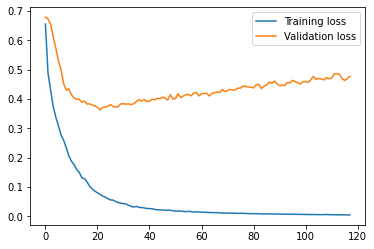

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
#if not trial:
plt.savefig("output.png")
plt.show()

In [26]:
batched = False
def test(val_dl,show_predictions=False):
    real_and_predictions = []
    model.eval()
    total_loss = []
    accuracy_list = []
    
    with torch.no_grad():
    
        for i, (xval,yval) in enumerate(val_dl):
            xval = xval.to(device)
            yvalc = yval.to(device)

            output_val = model(xval.float())

            accuracy = get_accuracy(output_val,yval)

            accuracy_list.append(accuracy)

            loss_val = criterion(output_val, yvalc.long())

            total_loss.append(loss_val.item())
            
            #print (one_hot_to_index(yvalc)[0],one_hot_to_index(output_val)[0])
            if show_predictions:
                if batched:
                    compound_list_original = index_to_word(yval_reshapedc.cpu().detach().numpy())
                    
                    compound_list_predicted = []
                    for i,entry in enumerate(output_val.view(len(yval_reshaped),-1,len(vocab))):
                        softmax = torch.exp(entry.float())
                        prob = list(softmax.cpu().detach().numpy())
                        predictions = np.argmax(prob, axis=1)
                        #print (predictions.shape,output_val.shape,len(compound_list_original[i]))
                        pred = ""
                        for i,entry in enumerate(predictions):
                            pred += index_word[entry]
                        compound_list_predicted.append(pred) 
                        
                    for i in range(len(compound_list_original)):
                        real_and_predictions.append((compound_list_original[i],compound_list_predicted[i]))
                else:
                    pred = ""
                    real = ""
                    softmax = torch.exp(output_val.float())
                    prob = list(softmax.cpu().detach().numpy())
                    predictions = np.argmax(prob, axis=1)
                    '''for i,entry in enumerate(predictions):
                        pred += en_index_word[entry]
                        #print (i)
                        real += en_index_word[yvalc.cpu().detach().numpy()[i]]
                        print (real)'''
                        
                    real_and_predictions.append((yvalc.cpu().detach().numpy(),predictions))
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)),real_and_predictions)

In [27]:
loss,accuracy,prediction_list_valid = test(val_loader,True)
loss,accuracy

(0.34842103719711304, 0.890625)

In [28]:
loss,accuracy,prediction_list_test = test(test_loader,True)
loss,accuracy

(0.30730391293764114, 0.890625)

In [29]:
loss,accuracy,prediction_list_train = test(train_loader,True)
loss,accuracy

(0.025854728184640408, 1.0)

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
def get_truth_pred(prediction_list):
    y_ground_truth = []
    y_predicted = []
    for entry in prediction_list:
        y_ground_truth.extend(entry[0])
        y_predicted.extend(entry[1])
    return (y_ground_truth,y_predicted)

def confustion_matrix(prediction_list,output_type="test"):
    y_ground_truth,y_predicted =   get_truth_pred(prediction_list)
    
    cm= sklearn.metrics.confusion_matrix(y_ground_truth,y_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 
    #print (cm_train)
    #tn, fp, fn, tp = cm.ravel()
    
    #if not trial:
    #    log_file.write(str(output_type) +" \t - tn, fp, fn, tp = " + str(tn) + " " + str(fp) + " " + str(fn) + " " + str(tp) + "\n")
    #return tn, fp, fn, tp

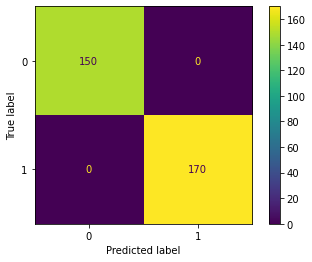

In [31]:
confustion_matrix(prediction_list_train,output_type="train")

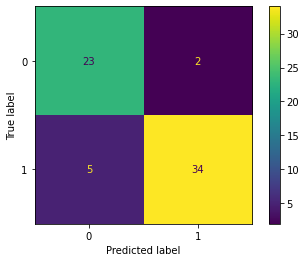

In [32]:
confustion_matrix(prediction_list_valid,output_type="valid")

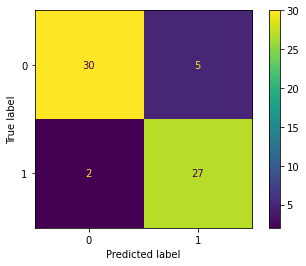

In [33]:
confustion_matrix(prediction_list_test,output_type="test")